# MIT (TA1): From Paper and Code to annotated Petri Nets

#### Mike Cafarella, Chunwei Liu, Markos Markakis, Peter Chen

## 0. Preprocessing

In [2]:
import ast, json, requests, os
from IPython import display
from gpt_key import *

API_ROOT = "http://100.26.10.46/"

#### Starting with the SIDARTHE [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7175834/pdf/41591_2020_Article_883.pdf) provided in Scenario 2,  we can run COSMOS (thanks Enrique Noriega from UArizona!) to extract a JSON with entries like this:
    

In [3]:
with open("documents_sidarthe--COSMOS-data.json", "r") as f:
    cosmos = f.read()
    print(ast.literal_eval(cosmos)[0])

{'pdf_name': '41591_2020_Article_883.pdf', 'dataset_id': 'documents_5Feb', 'page_num': 1, 'img_pth': '/mytmp/images/41591_2020_Article_883.pdf_1_pad', 'pdf_dims': [0.0, 0.0, 612.0, 792.0], 'bounding_box': [103.0, 51.0, 1341.0, 212.0], 'classes': ['Section Header', 'Page Footer', 'Figure', 'Body Text', 'Other', 'Reference text', 'Equation', 'Page Header', 'Abstract', 'Table Caption', 'Figure Caption', 'Table', 'Table Note', 'Equation label'], 'scores': [-5.5183234215, -7.2636179924, -7.3330821991, -8.6994543076, -8.9685325623, -9.0146894455, -9.3787899017, -9.9470386505, -10.0574893951, -10.3444986343, -10.5733766556, -11.2742881775, -11.5064592361, -12.4296512604], 'content': '', 'postprocess_cls': 'Page Header', 'postprocess_score': 0.8623757958, 'detect_cls': 'Section Header', 'detect_score': -5.5183234215}


#### We can run a local script to consolidate the "content" fields to get just the text of the paper:

In [4]:
with open("sidarthe.txt", "r") as f:
    text = f.read()
    print(text.replace('\n', ' ')[:500])

 Modelling the COVID-19 epidemic and implementation of population-wide Modelling the COVID-19 epidemic and implementation of population-wide interventions in Italy Giulia Giordano 1 ✉, Franco Blanchini2, Raffaele Bruno3,4, Patrizio Colaneri5,6, Alessandro Di Filippo3, Angela Di Matteo3 and Marta Colaneri3 In Italy, 128,948 confirmed cases and 15,887 deaths of peo- discharged due to recovery and 15,887 had died7. In the early days of ple  who  tested  positive  for  SARS-CoV-2  were  registered  


#### From the COSMOS output, we can also keep metadata like the paper name and doi for later:

In [5]:
with open("sidarthe_info.json", "r") as f:
    info = json.load(f)
    info_str = json.dumps(info)
    print(info_str)

{"pdf_name": "41591_2020_Article_883.pdf", "DOI": "https://doi.org/10.1038/s41591-020-0883-7"}


## 1. Extracting variables and annotating them from the text and the DKG

#### Using our API (powered by GPT-3), we can extract variables from the paper alongside a list of possible definitions, and ground each of these variables to the MIRA DKG (thanks Harvard team!). If you're interested, the JSON format of our intermediate output can be found [here](https://github.com/mikecafarella/mitaskem/blob/main/JSONformat.md).

In [6]:
with open("sidarthe_short.txt", "r") as f:
        text = f.read()           
        dct_extract = {"text":text, "gpt_key":GPT_KEY}           
        json_str = requests.post(API_ROOT + "annotation/find_text_vars/", params=dct_extract).text
json_str

'[{"type":"variable","name":"S","id":"v0","text_annotations":[" Susceptible (uninfected)"],"dkg_annotations":[[""]]},{"type":"variable","name":"I","id":"v1","text_annotations":[" Infected (asymptomatic or pauci-symptomatic infected, undetected)"],"dkg_annotations":[[""]]},{"type":"variable","name":"D","id":"v2","text_annotations":[" Diagnosed (asymptomatic infected, detected)"],"dkg_annotations":[[""]]},{"type":"variable","name":"A","id":"v3","text_annotations":[" Ailing (symptomatic infected, undetected)"],"dkg_annotations":[[""]]},{"type":"variable","name":"R","id":"v4","text_annotations":[" Recognized (symptomatic infected, detected)"],"dkg_annotations":[[""]]},{"type":"variable","name":"T","id":"v5","text_annotations":[" Threatened (infected with life-threatening symptoms, detected)"],"dkg_annotations":[[""]]},{"type":"variable","name":"H","id":"v6","text_annotations":[" Healed (recovered)"],"dkg_annotations":[[""]]},{"type":"variable","name":"E","id":"v7","text_annotations":[" Ext

In [7]:
ast.literal_eval(json_str)

[{'type': 'variable',
  'name': 'S',
  'id': 'v0',
  'text_annotations': [' Susceptible (uninfected)'],
  'dkg_annotations': [['']]},
 {'type': 'variable',
  'name': 'I',
  'id': 'v1',
  'text_annotations': [' Infected (asymptomatic or pauci-symptomatic infected, undetected)'],
  'dkg_annotations': [['']]},
 {'type': 'variable',
  'name': 'D',
  'id': 'v2',
  'text_annotations': [' Diagnosed (asymptomatic infected, detected)'],
  'dkg_annotations': [['']]},
 {'type': 'variable',
  'name': 'A',
  'id': 'v3',
  'text_annotations': [' Ailing (symptomatic infected, undetected)'],
  'dkg_annotations': [['']]},
 {'type': 'variable',
  'name': 'R',
  'id': 'v4',
  'text_annotations': [' Recognized (symptomatic infected, detected)'],
  'dkg_annotations': [['']]},
 {'type': 'variable',
  'name': 'T',
  'id': 'v5',
  'text_annotations': [' Threatened (infected with life-threatening symptoms, detected)'],
  'dkg_annotations': [['']]},
 {'type': 'variable',
  'name': 'H',
  'id': 'v6',
  'text_ann

## 2. Adding annotations from dataset columns

#### Alongside the text, we might also have discovered a collection of datasets that we think might be relevant:

In [57]:
with open("../../resources/dataset/covid_confirmed_usafacts.csv") as f:
    dataset_1 = f.read()
    print(dataset_1[:150])

countyFIPS,County Name,State,StateFIPS,2020-01-22
0,"Statewide Unallocated","AL","01",0
1001,"Autauga County ","AL","01",0


In [58]:
with open("../../resources/dataset/covid_deaths_usafacts.csv") as f:
    dataset_2 = f.read()
    print(dataset_2[:150])

countyFIPS,County Name,State,StateFIPS,2020-01-22
0,"Statewide Unallocated","AL","01",0
1001,"Autauga County ","AL","01",0


#### Let's collect just the column names into a single file:

In [66]:
dir = "../../resources/dataset/"
with open(os.path.join(dir,"headers.txt"), "w+") as fw:
    for filename in os.listdir(dir):
        file = os.path.join(dir, filename)
        if os.path.isfile(file) and file.endswith(".csv"):
            fw.write("{}:\t{}".format(filename, open(file, "r").readline()))

In [69]:
with open(os.path.join(dir,"headers.txt")) as f:
    dataset_str = f.read()
    print(dataset_str[:419])

COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Archive_Repository.csv:	Update Date,Days Since Update,User,Rows,Row Change,Columns,Column Change,Metadata Published,Metadata Updates,Column Level Metadata,Column Level Metadata Updates,Archive Link
covid_confirmed_usafacts.csv:	countyFIPS,County Name,State,StateFIPS,2020-01-22
covid_deaths_usafacts.csv:	countyFIPS,County Name,State,StateFIPS,2020-01-22



#### Now we can call our `annotation/link_datasets_to_vars` endpoint to map variables discovered earlier to any matching dataset columns (GIGO warning here):

In [1]:
dct_cols = {"json_str":json_str, "dataset_str": dataset_str, "gpt_key":GPT_KEY}           
json_str = requests.post(API_ROOT + "annotation/link_datasets_to_vars/", params=dct_cols).text

NameError: name 'json_str' is not defined

In [39]:
ast.literal_eval(json_str)

[{'type': 'variable',
  'name': 'S',
  'id': 'v0',
  'text_annotations': [' Susceptible (uninfected)'],
  'dkg_annotations': [['ncit:C171133', 'COVID-19 Infection'],
   ['ido:0000514', 'susceptible population']],
  'data_annotations': [['covid_tracking.csv', 'negative'],
   ['covid_tracking.csv', 'totalTestResults']]},
 {'type': 'variable',
  'name': 'I',
  'id': 'v1',
  'text_annotations': [' Infected (asymptomatic or pauci-symptomatic infected, undetected)'],
  'dkg_annotations': [['ido:0000511', 'infected population'],
   ['ncit:C171133', 'COVID-19 Infection']],
  'data_annotations': [['covid_tracking.csv', 'positive'],
   ['covid_tracking.csv', 'probableCases']]},
 {'type': 'variable',
  'name': 'D',
  'id': 'v2',
  'text_annotations': [' Diagnosed (asymptomatic infected, detected)'],
  'dkg_annotations': [['ido:0000511', 'infected population'],
   ['ncit:C171133', 'COVID-19 Infection']],
  'data_annotations': [['covid_tracking.csv', 'positive'],
   ['covid_tracking.csv', 'totalTes

## 3. Extracting LaTeX from formula images

####  Here is a formula image from the SIDARTHE paper:

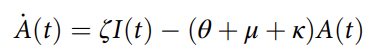

In [40]:
display.Image("../../resources/images/SIDARTHE/sidarthe_dAdt.png")

#### As we demoed last week, we can extract LaTeX from such formula images (powered by `pix2tex`), also through a public API.

In [41]:
directory = '../../resources/images/SIDARTHE'
latex_strs = []
 
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    latex_str = !python3 img_latex.py -p {f} # This is a local script that resizes the image and calls the public API.
    latex_strs.append(latex_str[0])

print(latex_strs)

['"{\\\\dot{A}}(t)=\\\\zeta I(t)-(\\\\theta+\\\\mu+\\\\kappa)A(t)"', '"{\\\\dot{D}}(t)=\\\\varepsilon I(t)-(\\\\eta+\\\\rho)D(t)"', '"\\\\dot{\\\\bar{F}}(t)\\\\,\\\\longrightarrow\\\\,\\\\tau\\\\,T(t)"', '"H(t)=i I(t)+\\\\theta b(t)+\\\\kappa d(t)+i R(t)+\\\\sigma T(t)"', '"\\\\scriptstyle I_{\\\\theta\\\\theta}=\\\\delta\\\\theta\\\\theta\\\\theta+I_{\\\\theta\\\\theta}+\\\\gamma\\\\xi\\\\theta_{1}+\\\\delta\\\\theta_{1})-\\\\epsilon+\\\\xi+\\\\delta I_{\\\\theta}"', '"R(t)=\\\\eta D(t)+\\\\theta A(t)-(\\\\nu+\\\\xi)R(t)"', '"\\\\delta(t)=-S(t)(a l(t)+\\\\theta D(t)+r A(t)+\\\\delta t(t)"', '"{\\\\hat{T}}(t)=\\\\mu A(t)+\\\\nu R(t)-(\\\\sigma+\\\\tau){\\\\hat{T}}(t)"']


## 4. Linking variables from the LaTeX formulas to variables from the text

#### We just extracted all these equations in LaTeX, which include variables. Let's link these variables to the variables we found from the text in part 1.  Again, the output (internal)JSON format can be found [here](https://github.com/mikecafarella/mitaskem/blob/main/JSONformat.md)

In [42]:
for latex_str in latex_strs:
    dct_latex = {"json_str":json_str, "formula": latex_str, "gpt_key":GPT_KEY}           
    json_str = requests.post(API_ROOT + "annotation/link_latex_to_vars/", params=dct_latex).text

In [43]:
ast.literal_eval(json_str)

[{'type': 'variable',
  'name': 'S',
  'id': 'v0',
  'text_annotations': [' Susceptible (uninfected)'],
  'dkg_annotations': [['ncit:C171133', 'COVID-19 Infection'],
   ['ido:0000514', 'susceptible population']],
  'data_annotations': [['covid_tracking.csv', 'negative'],
   ['covid_tracking.csv', 'totalTestResults']]},
 {'type': 'variable',
  'name': 'I',
  'id': 'v1',
  'text_annotations': [' Infected (asymptomatic or pauci-symptomatic infected, undetected)'],
  'dkg_annotations': [['ido:0000511', 'infected population'],
   ['ncit:C171133', 'COVID-19 Infection']],
  'data_annotations': [['covid_tracking.csv', 'positive'],
   ['covid_tracking.csv', 'probableCases']]},
 {'type': 'variable',
  'name': 'D',
  'id': 'v2',
  'text_annotations': [' Diagnosed (asymptomatic infected, detected)'],
  'dkg_annotations': [['ido:0000511', 'infected population'],
   ['ncit:C171133', 'COVID-19 Infection']],
  'data_annotations': [['covid_tracking.csv', 'positive'],
   ['covid_tracking.csv', 'totalTes

## 5. Getting a Petri net (as a pyascet) from code 

#### Let's now turn our attention to code. We have a python function that describes the SIDARTHE dynamics:

In [44]:
with open("../../resources/jan_evaluation/scenario_2_sidarthe/sidarthe_code.py", "r") as f:
    code = f.read()
print(code)

# define SIDARTHE_model
def SIDARTHE_model(y, t, alpha, beta, gamma, delta, epsilon, mu, zeta, lamda, eta, rho, theta, kappa, nu, xi, sigma, tau):
    S, I, D, A, R, T, H, E = y
    dSdt = -S*(alpha(t)*I + beta(t)*D + gamma(t)*A + delta(t)*R)
    dIdt = S*(alpha(t)*I + beta(t)*D + gamma(t)*A + delta(t)*R) - (epsilon(t) + zeta(t) + lamda(t))*I
    dDdt = epsilon(t)*I - (eta(t) + rho(t))*D
    dAdt = zeta(t)*I - (theta(t) + mu(t) + kappa(t))*A
    dRdt = eta(t)*D + theta(t)*A - (nu(t) + xi(t))*R
    dTdt = mu(t)*A + nu(t)*R - (sigma(t) + tau(t))*T
    dHdt = lamda(t)*I + rho(t)*D + kappa(t)*A + xi(t)*R + sigma(t)*T
    dEdt = tau(t)*T
    
    return dSdt, dIdt, dDdt, dAdt, dRdt, dTdt, dHdt, dEdt


#### Using calls to the public MIT API, we can get Petri net components (places, transitions, hypothesized arcs) from this piece of code.

In [45]:
dict_petri = {"code": code, "gpt_key": GPT_KEY}
places = requests.post(API_ROOT + "petri/get_places", params=dict_petri).text
ast.literal_eval(places)

['S', ' I', ' D', ' A', ' R', ' T', ' H', ' E']

In [46]:
transitions = requests.post(API_ROOT + "petri/get_transitions", params=dict_petri).text
ast.literal_eval(transitions)

['alpha',
 ' beta',
 ' gamma',
 ' delta',
 ' epsilon',
 ' mu',
 ' zeta',
 ' lamda',
 ' eta',
 ' rho',
 ' theta',
 ' kappa',
 ' nu',
 ' xi',
 ' sigma',
 ' tau']

In [47]:
arcs = requests.post(API_ROOT + "petri/get_arcs", params=dict_petri).text
ast.literal_eval(arcs)

[['S', ' I'],
 ['I', ' D'],
 ['I', ' A'],
 ['I', ' R'],
 ['D', ' E'],
 ['A', ' R'],
 ['A', ' T'],
 ['R', ' H'],
 ['T', ' H'],
 ['I', ' H'],
 ['D', ' H'],
 ['A', ' H'],
 ['R', ' H'],
 ['T', ' E']]

#### We can then convert these outputs into a py-acset (thanks to Justin Lieffers from Arizona for some of the conversion code and to Owen Lynch for the py-acset code!)

In [48]:
dict_acset = {"places_str": places, "transitions_str": transitions, "arcs_str": arcs}
pyacset_str = requests.post(API_ROOT + "petri/get_pyacset", params=dict_acset).text

In [49]:
ast.literal_eval(pyacset_str)

{'S': [{'sname': 'S', 'uid': 1},
  {'sname': 'I', 'uid': 2},
  {'sname': 'D', 'uid': 3},
  {'sname': 'A', 'uid': 4},
  {'sname': 'R', 'uid': 5},
  {'sname': 'T', 'uid': 6},
  {'sname': 'H', 'uid': 7},
  {'sname': 'E', 'uid': 8}],
 'T': [{'tname': 'alpha', 'uid': 10},
  {'tname': ' beta', 'uid': 11},
  {'tname': ' gamma', 'uid': 12},
  {'tname': ' delta', 'uid': 13},
  {'tname': ' epsilon', 'uid': 14},
  {'tname': ' mu', 'uid': 15},
  {'tname': ' zeta', 'uid': 16},
  {'tname': ' lamda', 'uid': 17},
  {'tname': ' eta', 'uid': 18},
  {'tname': ' rho', 'uid': 19},
  {'tname': ' theta', 'uid': 20},
  {'tname': ' kappa', 'uid': 21},
  {'tname': ' nu', 'uid': 22},
  {'tname': ' xi', 'uid': 23},
  {'tname': ' sigma', 'uid': 24},
  {'tname': ' tau', 'uid': 25}],
 'I': [{'it': 1, 'is': 1},
  {'it': 2, 'is': 2},
  {'it': 3, 'is': 2},
  {'it': 4, 'is': 2},
  {'it': 5, 'is': 3},
  {'it': 6, 'is': 4},
  {'it': 7, 'is': 4},
  {'it': 8, 'is': 5},
  {'it': 9, 'is': 6},
  {'it': 10, 'is': 2},
  {'it': 1

## 6. Linking the annotations to the py-acset and paper info

#### Finally, we bring everything together: for every place and transition in the pyacset, let's map it to the annotations from earlier:

In [50]:
dct_link = {"pyacset_str":pyacset_str, "annotations_str":json_str, "info_str":info_str}           
metadata_str = requests.post(API_ROOT + "annotation/link_annos_to_pyacset/", params=dct_link).text

In [51]:
ast.literal_eval(metadata_str)

{'1': {'type': 'variable',
  'name': 'S',
  'id': 'v0',
  'text_annotations': [' Susceptible (uninfected)'],
  'dkg_annotations': [['ncit:C171133', 'COVID-19 Infection'],
   ['ido:0000514', 'susceptible population']],
  'data_annotations': [['covid_tracking.csv', 'negative'],
   ['covid_tracking.csv', 'totalTestResults']],
  'equation_annotations': {'\\delta(t)=-S(t)(a l(t)+\\theta D(t)+r A(t)+\\delta t(t)': ['S']},
  'file': '41591_2020_Article_883.pdf',
  'doi': 'https://doi.org/10.1038/s41591-020-0883-7'},
 '2': {'type': 'variable',
  'name': 'I',
  'id': 'v1',
  'text_annotations': [' Infected (asymptomatic or pauci-symptomatic infected, undetected)'],
  'dkg_annotations': [['ido:0000511', 'infected population'],
   ['ncit:C171133', 'COVID-19 Infection']],
  'data_annotations': [['covid_tracking.csv', 'positive'],
   ['covid_tracking.csv', 'probableCases']],
  'equation_annotations': {'{\\dot{A}}(t)=\\zeta I(t)-(\\theta+\\mu+\\kappa)A(t)': ['I'],
   '{\\dot{D}}(t)=\\varepsilon I(t)

#### Data in this format can be ingested, visualized and edited by TA4! Let's export the related files:

In [52]:
with open("output-mit-pyacset.json", "w+") as f:
    json.dump(ast.literal_eval(pyacset_str), f)
with open("output-mit-metadata.json", "w+") as f:
    json.dump(ast.literal_eval(metadata_str), f)

## 7. Interacting with the University of Arizona codepaths

#### The University of Arizona team can also produce an annotated py-acset as an output. We can integrate the two outputs by matching on the names of places and transitions, to get a more complete picture of the model. The metadata extracted by both teams can then be accessible by using the associated `uid` of each place/transition as a key into the metadata JSON file.